In [1]:
#Lista3 - UFABC - Laurindo dos Santos - 131710114

In [2]:
from pyspark import SparkContext

In [3]:
sc = SparkContext()

In [4]:
import os
import numpy as np

filename = "c:\\Data\\Aula03\\Crime.csv"
CrimeRDD = sc.textFile(filename,8)
header = CrimeRDD.take(1)[0] # o cabeçalho é a primeira linha do arquivo

print ("Campos disponíveis: {}".format(header))

Campos disponíveis: Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y


In [5]:
# EXERCICIO
CrimeHeadlessRDD = CrimeRDD.filter(lambda x: x != header)

firstObject = CrimeHeadlessRDD.take(1)[0]
print (firstObject)

2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747


In [6]:
assert firstObject=='2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747', 'valor incorreto'
print ("OK")

OK


In [7]:
# EXERCICIO
CrimeHeadlessRDD = (CrimeRDD
                        .filter(lambda x: x != header)
                        .map(lambda x: x.split(","))
                        .collect()
                    )

firstObjectList = CrimeHeadlessRDD[0]

print (firstObjectList)

['2015-05-13 23:53:00', 'WARRANTS', 'WARRANT ARREST', 'Wednesday', 'NORTHERN', '"ARREST', ' BOOKED"', 'OAK ST / LAGUNA ST', '-122.425891675136', '37.7745985956747']


In [8]:
assert firstObjectList[0]=='2015-05-13 23:53:00', 'valores incorretos'
print ("OK")

OK


In [9]:
# EXERCICIO

import re
import datetime
from collections import namedtuple

headeritems = header.split(',') # transformar o cabeçalho em lista
del headeritems[-1] # apagar o último item e...
headeritems[-1] = 'COORD' # transformar em COORD

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD
Crime = namedtuple('Crime',headeritems) # gera a namedtuple Crime com os campos de header

REGEX = r',(?=(?:[^"]*"[^"]*")*(?![^"]*"))'
# buscar por "," tal que após essa vírgula (?=) ou exista um par de "" ou não tenha " sozinha
# ?= indica para procurarmos pelo padrão após a vírgula
# ?: significa para não interpretar os parênteses como captura de valores
# [^"]* 0 ou sequências de caracteres que não sejam aspas
# [^"]*"[^"]*"  <qualquer caracter exceto aspas> " <qualquer caracter exceto aspas> "
# ?! indica para verificar se não existe tal padrão a frente da vírgula

def ParseCrime(rec):
    # utilizando re.split() vamos capturar nossos valores
    
    #for line in rec:
    Dates, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = re.split(REGEX, rec.strip())
    
    #Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = rec.foreach(lambda x: re.split(REGEX, x))    
    
    # Converta a data para o formato datetime
    Dates = datetime.datetime.strptime(Dates, "%Y-%m-%d %H:%M:%S")

    # COORD é uma tupla com floats representando X e Y
    COORD = (float(X), float(Y))

    # O campos 'Resolution' será uma lista dos valores separados por vírgula, sem as aspas
    Resolution = Resolution.strip('",').split()

    return Crime(Dates, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, COORD)


# Aplique a função ParseCrime para cada objeto da base
CrimeHeadlessRDD = sc.parallelize(CrimeRDD
                                    .filter(lambda x: x != header)
                                    .map(lambda x: ParseCrime(x))
                                    .collect()
                                 )



firstClean = CrimeHeadlessRDD.first()
totalRecs = CrimeHeadlessRDD.count()
print (firstClean)

Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category='WARRANTS', Descript='WARRANT ARREST', DayOfWeek='Wednesday', PdDistrict='NORTHERN', Resolution=['ARREST,', 'BOOKED'], Address='OAK ST / LAGUNA ST', COORD=(-122.425891675136, 37.7745985956747))


In [10]:
assert type(firstClean.Dates) is datetime.datetime and type(firstClean.Resolution) is list and type(firstClean.COORD) is tuple,'tipos incorretos'
print ("OK")

assert CrimeHeadlessRDD.filter(lambda x: len(x)!=8).count()==0, 'algo deu errado!'
print ("OK")

assert totalRecs==878049, 'total de registros incorreto'
print ("OK")

OK
OK
OK


In [11]:
# EXERCICIO

CatCountRDD = sc.parallelize(CrimeHeadlessRDD
                                 .map(lambda x: (x.Category, 1))
                                 .groupByKey()
                                 .mapValues(sum)
                                 .collect()
                            )

catCount = sorted(CatCountRDD.collect(), key=lambda x: -x[1])

print (catCount)


[('LARCENY/THEFT', 174900), ('OTHER OFFENSES', 126182), ('NON-CRIMINAL', 92304), ('ASSAULT', 76876), ('DRUG/NARCOTIC', 53971), ('VEHICLE THEFT', 53781), ('VANDALISM', 44725), ('WARRANTS', 42214), ('BURGLARY', 36755), ('SUSPICIOUS OCC', 31414), ('MISSING PERSON', 25989), ('ROBBERY', 23000), ('FRAUD', 16679), ('FORGERY/COUNTERFEITING', 10609), ('SECONDARY CODES', 9985), ('WEAPON LAWS', 8555), ('PROSTITUTION', 7484), ('TRESPASS', 7326), ('STOLEN PROPERTY', 4540), ('SEX OFFENSES FORCIBLE', 4388), ('DISORDERLY CONDUCT', 4320), ('DRUNKENNESS', 4280), ('RECOVERED VEHICLE', 3138), ('KIDNAPPING', 2341), ('DRIVING UNDER THE INFLUENCE', 2268), ('RUNAWAY', 1946), ('LIQUOR LAWS', 1903), ('ARSON', 1513), ('LOITERING', 1225), ('EMBEZZLEMENT', 1166), ('SUICIDE', 508), ('FAMILY OFFENSES', 491), ('BAD CHECKS', 406), ('BRIBERY', 289), ('EXTORTION', 256), ('SEX OFFENSES NON FORCIBLE', 148), ('GAMBLING', 146), ('PORNOGRAPHY/OBSCENE MAT', 22), ('TREA', 6)]


In [12]:
assert catCount[0][1]==174900, 'valores incorretos'
print ("OK")

OK


In [13]:
# EXERCICIO

RegionCountRDD = sc.parallelize(CrimeHeadlessRDD
                                  .map(lambda x: (x.PdDistrict, 1))
                                  .groupByKey()
                                  .mapValues(sum)
                                  .collect()
                               )

regCount = sorted(RegionCountRDD.collect(), key=lambda x: -x[1])

print (regCount)

[('SOUTHERN', 157182), ('MISSION', 119908), ('NORTHERN', 105296), ('BAYVIEW', 89431), ('CENTRAL', 85460), ('TENDERLOIN', 81809), ('INGLESIDE', 78845), ('TARAVAL', 65596), ('PARK', 49313), ('RICHMOND', 45209)]


In [14]:
assert regCount[0][1]==157182, 'valores incorretos'
print ("OK")

OK


In [15]:
# EXERCICIO

from operator import add

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = sc.parallelize(CrimeHeadlessRDD
                                  .map(lambda x: (x.DayOfWeek, day2str(x.Dates),  1))
                                  .distinct()
                                  .map(lambda x: (x[0], x[2]))
                                  .groupByKey()
                                  .mapValues(sum)
                                  .collect()
                               )

crimesWeekDayRegionRDD = sc.parallelize(CrimeHeadlessRDD
                                           .map(lambda x: ((x.DayOfWeek, x.PdDistrict), 1))
                                           .groupByKey()
                                           .mapValues(sum)
                                           .map(lambda x: (x[0][0], (x[0][1], x[1])))
                                           .collect()
                                       )

RegionAvgPerDayRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: (x[0], (x[1][1][0], float(x[1][1][1]) / float(x[1][0]))))
                                         .groupByKey()
                                         .mapValues(list)
                                         .collect()
                                   )

RegionAvg = RegionAvgPerDayRDD.collectAsMap()
print (RegionAvg['Sunday'])

[('SOUTHERN', 64.82866043613707), ('BAYVIEW', 37.27414330218068), ('PARK', 20.70404984423676), ('MISSION', 49.45171339563863), ('CENTRAL', 37.99688473520249), ('INGLESIDE', 32.230529595015575), ('TENDERLOIN', 31.707165109034268), ('TARAVAL', 25.953271028037385), ('RICHMOND', 18.968847352024923), ('NORTHERN', 44.45794392523364)]


In [16]:
RegionAvgPerDayRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: ((x[0], x[1][1][0]), float(x[1][1][1]) / float(x[1][0])))
                                         .groupByKey()
                                         .mapValues(list)
                                         .collect()
                                   )

RegionAvg = RegionAvgPerDayRDD.collectAsMap()


In [17]:
assert np.round(RegionAvg['Sunday', 'BAYVIEW'],2)==37.27, 'valores incorretos {}'.format(np.round(RegionAvg[0][2],2))
print ("OK")

OK


In [18]:
# EXERCICIO

countWeekDayDistRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: ((x[0], (x[1][1][0])), float(x[1][1][1]) / float(x[1][0])))
                                         .groupByKey()
                                         .mapValues(sum)
                                         .collect()
                                   )

# Esse procedimento só é viável se existirem poucas chaves
RegionAvgSpark = {}
Keys = countWeekDayDistRDD.map(lambda rec: rec[0]).collect()

for key in Keys:

    listRDD = (countWeekDayDistRDD.filter(lambda rec: rec[0][0]==key[0]).map(lambda rec: float(rec[1])))

    if key[0] not in RegionAvgSpark:
        RegionAvgSpark[key[0]] = {}    
    RegionAvgSpark[key[0], key[1]] = (listRDD.mean(), listRDD.stdev())
    
print (RegionAvgSpark['Sunday'])

{}


In [19]:
assert np.round(RegionAvgSpark['Sunday', 'BAYVIEW'][0],2)==36.36 and np.round(RegionAvgSpark['Sunday', 'BAYVIEW'][1],2)==13.21, 'valores incorretos'
print ("OK")

OK


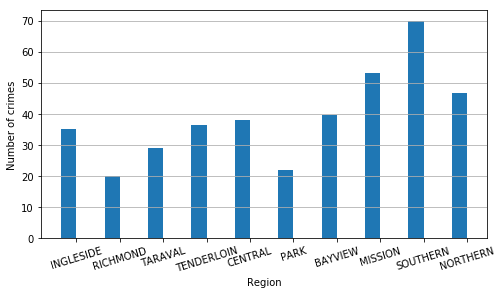

In [20]:
import matplotlib.pyplot as plt

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = (CrimeHeadlessRDD
                    .map(lambda rec: (day2str(rec.Dates),1))
                    .reduceByKey(lambda x,y: x)
                 )

totalDays = float(totalDatesRDD.count())

avgCrimesRegionRDD = (RegionCountRDD
                         .map(lambda rec: (rec[0],rec[1]/totalDays))
                     )

Xticks,Y = zip(*avgCrimesRegionRDD.collectAsMap().items())
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.bar(indices,Y, width)
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
plt.show()
pass

In [49]:
# Dias da semana como referência
Day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Uma cor para cada dia
Color = ['r','b','g','y','c','k','purple']

# Dicionário (dia, array de médias)
Y = {}
for day in Day:
    Y[day] = np.array([RegionAvg[day, x] for x in Xticks])
    print (Y[day])
    print (Xticks)
    print (Day[i-1])
# Matriz dias x regiões    

Bottom = np.zeros( (len(Day),len(Xticks)) )

for i in range (1,len(Day)):
    print(range(1,len(Day)))
    print (Bottom[i,:])
    print (Day[i-1])
    print (Y[Day[i-1]])
    Bottom[i,:] = [([1], [1], [1], [1], [1], [1], [1], [1], [1], [1])]
#    Bottom[i,:] = Bottom[i-1,:]+Y[Day[i-1]]
    
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')

# Gera uma lista de plots, um para cada dia
plots = [plt.bar(indices,Y[Day[i]], width, color=Color[i], bottom=Bottom[i]) for i in range(len(Day))]

plt.legend( [p[0] for p in plots], Day,loc='center left', bbox_to_anchor=(1, 0.5) ) 
    
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
pass

[[ 32.2305296 ]
 [ 18.96884735]
 [ 25.95327103]
 [ 31.70716511]
 [ 37.99688474]
 [ 20.70404984]
 [ 37.2741433 ]
 [ 49.4517134 ]
 [ 64.82866044]
 [ 44.45794393]]
('INGLESIDE', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'CENTRAL', 'PARK', 'BAYVIEW', 'MISSION', 'SOUTHERN', 'NORTHERN')
Sunday
[[ 35.03726708]
 [ 19.72670807]
 [ 28.7484472 ]
 [ 36.95031056]
 [ 34.56521739]
 [ 21.56832298]
 [ 39.2826087 ]
 [ 51.51242236]
 [ 65.78881988]
 [ 44.40993789]]
('INGLESIDE', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'CENTRAL', 'PARK', 'BAYVIEW', 'MISSION', 'SOUTHERN', 'NORTHERN')
Sunday
[[ 35.85714286]
 [ 20.11490683]
 [ 29.82919255]
 [ 38.8136646 ]
 [ 35.05900621]
 [ 21.33850932]
 [ 39.80124224]
 [ 53.67080745]
 [ 68.36335404]
 [ 45.24223602]]
('INGLESIDE', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'CENTRAL', 'PARK', 'BAYVIEW', 'MISSION', 'SOUTHERN', 'NORTHERN')
Sunday
[[ 36.2834891 ]
 [ 20.28971963]
 [ 30.53582555]
 [ 40.0623053 ]
 [ 36.59501558]
 [ 22.68224299]
 [ 41.97507788]
 [ 55.19314642]
 [ 71.38006231]
 [ 4

ValueError: setting an array element with a sequence.

ValueError: could not broadcast input array from shape (10,10) into shape (10)

In [241]:
RegionAvgPerDayRDD.first()
RegionAvgPerDayRDD.collectAsMap()

{'Friday': [('TENDERLOIN', 34.66978193146417),
  ('INGLESIDE', 37.01246105919003),
  ('RICHMOND', 21.339563862928348),
  ('TARAVAL', 31.797507788161994),
  ('NORTHERN', 50.875389408099686),
  ('SOUTHERN', 76.19314641744548),
  ('MISSION', 56.666666666666664),
  ('BAYVIEW', 42.61993769470405),
  ('PARK', 23.707165109034268),
  ('CENTRAL', 41.73520249221184)],
 'Monday': [('INGLESIDE', 35.037267080745345),
  ('TARAVAL', 28.748447204968944),
  ('TENDERLOIN', 36.95031055900621),
  ('RICHMOND', 19.726708074534162),
  ('NORTHERN', 44.409937888198755),
  ('MISSION', 51.51242236024845),
  ('SOUTHERN', 65.7888198757764),
  ('BAYVIEW', 39.28260869565217),
  ('PARK', 21.56832298136646),
  ('CENTRAL', 34.56521739130435)],
 'Saturday': [('BAYVIEW', 38.753894080996886),
  ('SOUTHERN', 72.51401869158879),
  ('MISSION', 53.62305295950156),
  ('PARK', 21.53582554517134),
  ('CENTRAL', 43.822429906542055),
  ('TARAVAL', 28.11214953271028),
  ('RICHMOND', 20.043613707165107),
  ('INGLESIDE', 33.785046728

[('SOUTHERN', 64.82866043613707), ('BAYVIEW', 37.27414330218068), ('PARK', 20.70404984423676), ('MISSION', 49.45171339563863), ('CENTRAL', 37.99688473520249), ('INGLESIDE', 32.230529595015575), ('TENDERLOIN', 31.707165109034268), ('TARAVAL', 25.953271028037385), ('RICHMOND', 18.968847352024923), ('NORTHERN', 44.45794392523364)]


In [247]:
RegionAvgPerDayRDD.collectAsMap()

{('Friday', 'BAYVIEW'): [42.61993769470405],
 ('Friday', 'CENTRAL'): [41.73520249221184],
 ('Friday', 'INGLESIDE'): [37.01246105919003],
 ('Friday', 'MISSION'): [56.666666666666664],
 ('Friday', 'NORTHERN'): [50.875389408099686],
 ('Friday', 'PARK'): [23.707165109034268],
 ('Friday', 'RICHMOND'): [21.339563862928348],
 ('Friday', 'SOUTHERN'): [76.19314641744548],
 ('Friday', 'TARAVAL'): [31.797507788161994],
 ('Friday', 'TENDERLOIN'): [34.66978193146417],
 ('Monday', 'BAYVIEW'): [39.28260869565217],
 ('Monday', 'CENTRAL'): [34.56521739130435],
 ('Monday', 'INGLESIDE'): [35.037267080745345],
 ('Monday', 'MISSION'): [51.51242236024845],
 ('Monday', 'NORTHERN'): [44.409937888198755],
 ('Monday', 'PARK'): [21.56832298136646],
 ('Monday', 'RICHMOND'): [19.726708074534162],
 ('Monday', 'SOUTHERN'): [65.7888198757764],
 ('Monday', 'TARAVAL'): [28.748447204968944],
 ('Monday', 'TENDERLOIN'): [36.95031055900621],
 ('Saturday', 'BAYVIEW'): [38.753894080996886],
 ('Saturday', 'CENTRAL'): [43.8224

In [251]:
countWeekDayDistRDD.map(lambda rec: rec[0]).collect()

[(datetime.datetime(2015, 5, 13, 23, 30), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 22, 30), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 21, 55), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 21, 30), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 21, 11), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 20, 15), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 18, 39), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 18, 15), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 17, 45), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 17, 27), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 16, 30), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 13, 47), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 13, 40), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 9, 30), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 9, 0), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 5, 10), 'Wednesday'),
 (datetime.datetime(2015, 5, 13, 1, 3), 'Wednesday'),
 (datetime.datetime(2015, 5, 12, 22, 36), 'Tuesday'),
